# 23BAI1097 ML Challenging Experiment

## Task Description
Grammatical Error Correction (GEC) for one of the following low-resource languages: Bangla, Hindi, Malayalam, Tamil, Telugu

**Malayalam** has been chosen for this experiment

Metric of evaluation: GLEU Score (ranges between 0 to 1)

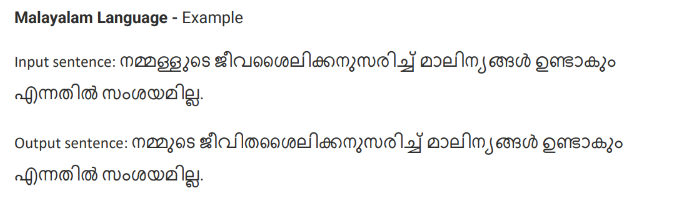



# Experiment Setup

In [ ]:
!pip install sentencepiece

In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.translate.gleu_score import sentence_gleu, corpus_gleu
import torch
from transformers import M2M100Config, M2M100ForConditionalGeneration, M2M100Tokenizer
from torch.optim import AdamW

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Upload datasets
from google.colab import files
files.upload()

In [ ]:
train_set = pd.read_csv("/content/train.csv")
test_set = pd.read_csv("/content/dev.csv")
print(train_set.columns)
print(len(train_set))

In [ ]:
train_set.dropna(inplace=True)
test_set.dropna(inplace=True)

X = train_set.iloc[:, 0].values
y = train_set.iloc[:, 1].values

X_val = test_set.iloc[:, 0].values
y_val = test_set.iloc[:, 1].values

In [ ]:
model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")
tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M", src_lang = "ta", tgt_lang = "ta")

In [ ]:
model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=2e-5)
batch_size = 4

In [ ]:
for i in range(0, len(X), batch_size):
  inputs = X[i: i+batch_size]
  targets = y[i: i+batch_size]

  # return_tensors = "pt" ensures the output is a pytorch tensor
  model_inputs = tokenizer(list(inputs), text_target=list(targets), padding=True, truncation=True, return_tensors="pt").to(model.device)

  outputs = model(**model_inputs)
  loss = outputs.loss
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()


In [ ]:
preds = []
refs = []

model.eval()
for inp, ref in list(zip(X_val, y_val)):
    encoded = tokenizer(inp, return_tensors="pt").to(model.device)
    generated = model.generate(**encoded, forced_bos_token_id=tokenizer.get_lang_id("ta"), max_length=128)
    pred = tokenizer.decode(generated[0], skip_special_tokens=True)
    preds.append([pred.split()])
    refs.append(ref.split())



In [ ]:
print(preds)
print(refs)

In [ ]:
score = corpus_gleu(preds, refs)
print("GLEU Score:", score)